## Project Setup

In [42]:
import io
import os
import pandas as pd
import requests
import warnings
from datetime import datetime
from pathlib import Path

warnings.filterwarnings("ignore")

In [43]:
datasets_dir = str(Path(os.path.abspath('')).parent.joinpath("datasets"))

In [44]:
owid_online_dataset = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

## OWID COVID-19 Dataset

### Dataset Fetch

In [45]:
"""
Try to fetch the most updated version of the CSV online,
if it fails, fallback to the saved filed
"""
raw_covid_df: pd.DataFrame
        
try:
  online_covid_data = requests.get(owid_online_dataset).content
  raw_covid_df = pd.read_csv(io.StringIO(online_covid_data.decode('utf-8')))
except:
  raw_covid_df = pd.read_csv(f"{datasets_dir}/owid-covid-data.csv")


### Dataset Cleanup

In [46]:
raw_covid_df.tail(3)

iso_code continent  location        date  total_cases  new_cases  \
61625      ZWE    Africa  Zimbabwe  2020-12-07      10839.0      121.0   
61626      ZWE    Africa  Zimbabwe  2020-12-08      10912.0       73.0   
61627      ZWE    Africa  Zimbabwe  2020-12-09      11007.0       95.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
61625             127.000         294.0         3.0                2.571  ...   
61626             111.857         303.0         9.0                3.714  ...   
61627             125.429         304.0         1.0                3.857  ...   

       gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
61625        1899.775             21.4                307.846   
61626        1899.775             21.4                307.846   
61627        1899.775             21.4                307.846   

       diabetes_prevalence  female_smokers  male_smokers  \
61625                 1.82             1.6          30.7   
61626                 1.82             1.6          30.7   
61627                 1.82             1.6          30.7   

       handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
61625                  36.791                         1.7            61.49   
61626                  36.791                         1.7            61.49   
61627                  36.791                         1.7            61.49   

       human_development_index  
61625                    0.535  
61626                    0.535  
61627                    0.535  

[3 rows x 50 columns]

In [47]:
to_year_month = lambda str_date: datetime\
                                  .strptime(str_date, "%Y-%m-%d")\
                                  .replace(day=1)

In [48]:
"""Inconsistent Data that needs to be purged"""

raw_covid_df[raw_covid_df['continent'].isnull()].head(5)

iso_code continent       location        date  total_cases  new_cases  \
25189      NaN       NaN  International  2020-01-23          NaN        0.0   
25190      NaN       NaN  International  2020-01-24          NaN        0.0   
25191      NaN       NaN  International  2020-01-25          NaN        0.0   
25192      NaN       NaN  International  2020-01-26          NaN        0.0   
25193      NaN       NaN  International  2020-01-27          NaN        0.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
25189                 NaN           NaN         0.0                  NaN  ...   
25190                 NaN           NaN         0.0                  NaN  ...   
25191                 NaN           NaN         0.0                  NaN  ...   
25192                 NaN           NaN         0.0                  NaN  ...   
25193                 NaN           NaN         0.0                  NaN  ...   

       gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
25189             NaN              NaN                    NaN   
25190             NaN              NaN                    NaN   
25191             NaN              NaN                    NaN   
25192             NaN              NaN                    NaN   
25193             NaN              NaN                    NaN   

       diabetes_prevalence  female_smokers  male_smokers  \
25189                  NaN             NaN           NaN   
25190                  NaN             NaN           NaN   
25191                  NaN             NaN           NaN   
25192                  NaN             NaN           NaN   
25193                  NaN             NaN           NaN   

       handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
25189                     NaN                         NaN              NaN   
25190                     NaN                         NaN              NaN   
25191                     NaN                         NaN              NaN   
25192                     NaN                         NaN              NaN   
25193                     NaN                         NaN              NaN   

       human_development_index  
25189                      NaN  
25190                      NaN  
25191                      NaN  
25192                      NaN  
25193                      NaN  

[5 rows x 50 columns]

In [49]:
""" Purging Bad Data """

staging_covid_df = raw_covid_df[raw_covid_df['continent'].notnull()].reset_index()

In [50]:
""" Includes a column that will be used to aggregate all data from the month/year """

staging_covid_df['year_month'] = staging_covid_df.apply(lambda row: to_year_month(row['date']), axis=1)

### Fixing Geographic Region for Countries

#### North and Central America

In [51]:
""" 
All countries in Central America, such as 'Cuba', 'Panama', 'Costa Rica', etc
are set with the continent as 'North America', let's fix that
"""

na_marked_countries = staging_covid_df.loc[ 
  (staging_covid_df['continent'] == 'North America')
]

na_marked_countries['location'].unique()

array(['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada',
       'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic',
       'El Salvador', 'Grenada', 'Guatemala', 'Haiti', 'Honduras',
       'Jamaica', 'Mexico', 'Nicaragua', 'Panama',
       'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Trinidad and Tobago',
       'United States'], dtype=object)

In [52]:
"""
All countries in 'continent' == 'North America that are NOT (~): 
'United States', 'Canada' or 'Mexico' should be set as 'Central America
"""

staging_covid_df.loc[ 
    (staging_covid_df['continent'] == 'North America') & 
    (~staging_covid_df['location'].isin(['United States', 'Canada', 'Mexico'])),
    'continent'
] = "Central America"

In [53]:
"""
All countries in Central America, such as 'Cuba', 'Panama', 'Costa Rica', etc
are set with the continent as 'North America', let's fix that
"""

na_countries = staging_covid_df.loc[ 
  (staging_covid_df['continent'] == 'North America')
]

na_countries['location'].unique()

array(['Canada', 'Mexico', 'United States'], dtype=object)

#### Eastern, Western, Northern, Southern Europe

In [54]:
#TODO

### Fixing Labels

In [55]:
""" Renames 'location' to 'country' """

staging_covid_df = staging_covid_df.rename(columns={
    'location': 'country'
})

## Data Aggregation

### Data Aggregation by Country by Period

In [56]:
"""
Sum of number of new_cases and Sum of number of new_deaths 
by aggregating values that havethe same country,and same period (year_month)
"""

covid_by_country_by_period = staging_covid_df\
                              .groupby(['country', 'iso_code', 'continent', 'year_month'])\
                              .agg({'new_cases': sum, 'new_deaths': sum})\
                              .sort_values(by=['year_month', 'country', 'continent'],
                                          ascending=[False, True, True])\
                              .reset_index()

In [57]:
covid_by_country_by_period[
  (covid_by_country_by_period['continent'] == 'North America') &
  (covid_by_country_by_period['year_month'] == '2020-03-01')
]

country iso_code      continent year_month  new_cases  new_deaths
1740         Canada      CAN  North America 2020-03-01     8507.0       101.0
1820         Mexico      MEX  North America 2020-03-01     1211.0        29.0
1890  United States      USA  North America 2020-03-01   192152.0      5271.0

### Data Aggregation by Continent by Period

In [58]:
"""
Sum of number of new_cases and Sum of number of new_deaths 
by aggregating values that have the same continent (location), and same period (year_month)

It's gonna be used to compute statistics for each continent
(standard_deviation, mean, median, etc)
"""
covid_by_continent_by_period = covid_by_country_by_period\
                                .groupby(['year_month', 'continent'])\
                                .agg({'new_cases': sum, 'new_deaths': sum})

In [59]:
covid_by_continent_by_period.loc[('2020-03-01', 'North America')]

new_cases     201870.0
new_deaths      5401.0
Name: (2020-03-01 00:00:00, North America), dtype: float64

### Data Aggregation by Period

In [60]:
"""
Sum of number of new_cases and Sum of number of new_deaths 
by aggregating values that have the same period (year_month)

It's gonna be used to compute global/world statistics 
(standard_deviation, mean, median, etc)
"""

covid_by_period_in_world = covid_by_country_by_period\
                            .groupby(['year_month'], as_index=['year_month'])\
                            .agg({'new_cases': sum, 'new_deaths': sum})

In [61]:
covid_by_period_in_world.tail(5)

new_cases  new_deaths
year_month                        
2020-08-01   7909300.0    175481.0
2020-09-01   8496243.0    164023.0
2020-10-01  12115195.0    181180.0
2020-11-01  17171268.0    272323.0
2020-12-01   5615614.0    100917.0

## Generating Statistics

### Base Statistics

In [62]:
"""
Generating statistics per Period (Year-Month) per Continent:
- count => number of countries reporting
- mean => aritmetic average 
- std => standard deviation

Note: Always consider the YEAR-MONTH for the 'year_month' field. 
      The DAY will always be '01'
"""
stats_by_period_by_continent = covid_by_country_by_period\
                                .groupby(['year_month', 'continent'])\
                                .describe()

stats_by_period_by_continent.tail(12)

new_cases                                        \
                               count          mean           std       min   
year_month continent                                                         
2020-11-01 Central America      20.0  5.866600e+03  9.953826e+03       3.0   
           Europe               46.0  1.604704e+05  2.392491e+05       0.0   
           North America         3.0  1.580304e+06  2.449032e+06  144244.0   
           Oceania               8.0  6.325000e+01  1.089741e+02       1.0   
           South America        12.0  1.221242e+05  2.322610e+05     109.0   
2020-12-01 Africa               54.0  2.448741e+03  6.843693e+03       0.0   
           Asia                 47.0  2.330632e+04  6.110518e+04    -112.0   
           Central America      20.0  2.444650e+03  4.323960e+03       0.0   
           Europe               46.0  3.862852e+04  5.458108e+04       0.0   
           North America         3.0  6.648827e+05  1.022480e+06   57585.0   
           Oceania               8.0  1.837500e+01  3.087272e+01       0.0   
           South America        12.0  4.728208e+04  1.112003e+05      21.0   

                                                                        \
                                  25%       50%         75%        max   
year_month continent                                                     
2020-11-01 Central America      38.00     902.0     6561.25    32208.0   
           Europe            12340.50   44004.0   173922.75   922124.0   
           North America    166412.50  188581.0  2298334.00  4408087.0   
           Oceania               2.00       8.5       75.25      317.0   
           South America      2896.50   21866.0   107418.00   800273.0   
2020-12-01 Africa               46.75     309.5     1086.75    38594.0   
           Asia                212.00    2834.0    15202.00   304562.0   
           Central America       9.50     139.5     3133.50    17171.0   
           Europe             3803.50   15836.5    51651.25   242615.0   
           North America     74635.50   91686.0   968531.50  1845377.0   
           Oceania               0.00       1.0       28.25       88.0   
           South America      2023.25    7132.5    23240.50   392574.0   

                           new_deaths                                      \
                                count          mean           std     min   
year_month continent                                                        
2020-11-01 Central America       20.0     91.100000    143.107946     0.0   
           Europe                46.0   2799.826087   4375.921451     0.0   
           North America          3.0  17688.333333  17740.066018  1960.0   
           Oceania                8.0      0.125000      0.353553     0.0   
           South America         12.0   2554.750000   4165.493556     6.0   
2020-12-01 Africa                54.0     53.296296    170.696976     0.0   
           Asia                  47.0    308.404255    773.251623   -13.0   
           Central America       20.0     31.700000     56.146519     0.0   
           Europe                46.0    972.695652   1486.517748     0.0   
           North America          3.0   9301.666667  10694.036765   862.0   
           Oceania                8.0      0.000000      0.000000     0.0   
           South America         12.0    855.083333   1673.362834     0.0   

                                                                 
                                25%      50%       75%      max  
year_month continent                                             
2020-11-01 Central America     0.75      9.5    101.50    442.0  
           Europe            120.75    736.5   2993.75  16958.0  
           North America    8073.50  14187.0  25552.50  36918.0  
           Oceania             0.00      0.0      0.00      1.0  
           South America      81.00    571.5   2497.00  13236.0  
2020-12-01 Africa              0.00      3.5     13.25   1039

In [63]:
"""
Generating GLOBAL statistics per Period (Year-Month):
- count => number of countries reporting  (numero de paises reportanto)
- mean => aritmetic average (média aritmetica)
- std => standard deviation (desvio padrao)

Note: Always consider the YEAR-MONTH for the 'year_month' field. 
      The DAY will always be '01'
"""

stats_by_period_in_world = covid_by_country_by_period\
                            .groupby(['year_month'])\
                            .describe()

stats_by_period_in_world.tail(6)

new_cases                                                      \
               count          mean            std    min     25%     50%   
year_month                                                                 
2020-07-01     190.0  37602.947368  186632.897220    0.0  182.75  1935.5   
2020-08-01     190.0  41627.894737  202451.062710  -70.0  243.50  2030.5   
2020-09-01     190.0  44717.068421  221662.749542    0.0  241.50  2242.0   
2020-10-01     190.0  63764.184211  220660.749245    0.0  205.25  3856.5   
2020-11-01     190.0  90375.094737  359382.390243    0.0  247.00  4904.5   
2020-12-01     190.0  29555.863158  142116.989540 -112.0   86.50  1852.5   

                                new_deaths                                   \
                 75%        max      count         mean          std    min   
year_month                                                                    
2020-07-01  12602.50  1922730.0      190.0   879.015789  3725.521133    0.0   
2020-08-01  12558.75  1995178.0      190.0   923.584211  3989.724206 -320.0   
2020-09-01  17464.25  2621418.0      190.0   863.278947  3599.958627   -2.0   
2020-10-01  30513.00  1915046.0      190.0   953.578947  3174.179066    0.0   
2020-11-01  41502.00  4408087.0      190.0  1433.278947  4074.878392    0.0   
2020-12-01  13969.75  1845377.0      190.0   531.142105  1855.885472  -13.0   

                                        
            25%   50%     75%      max  
year_month                              
2020-07-01  1.0  27.0  180.25  32881.0  
2020-08-01  2.0  28.0  220.75  29591.0  
2020-09-01  2.0  28.0  220.75  33390.0  
2020-10-01  2.0  35.0  334.00  23928.0  
2020-11-01  3.0  55.5  693.50  36918.0  
2020-12-01  1.0  25.0  244.50  21328.0

### New Cases - Statistics per Period per Continent

In [64]:
stats_cases_by_period_by_continent = stats_by_period_by_continent\
                                      .new_cases\
                                      .join(covid_by_continent_by_period)\
                                      .drop(['count', 'new_deaths'], axis=1)

stats_cases_by_period_by_continent

mean           std      min       25%  \
year_month continent                                                         
2020-01-01 Africa                0.000000  0.000000e+00      0.0      0.00   
           Asia                198.617021  1.349584e+03      0.0      0.00   
           Central America       0.000000  0.000000e+00      0.0      0.00   
           Europe                0.369565  1.122669e+00      0.0      0.00   
           North America         3.666667  3.511885e+00      0.0      2.00   
...                                   ...           ...      ...       ...   
2020-12-01 Central America    2444.650000  4.323960e+03      0.0      9.50   
           Europe            38628.521739  5.458108e+04      0.0   3803.50   
           North America    664882.666667  1.022480e+06  57585.0  74635.50   
           Oceania              18.375000  3.087272e+01      0.0      0.00   
           South America     47282.083333  1.112003e+05     21.0   2023.25   

                                50%        75%        max  new_cases  
year_month continent                                                  
2020-01-01 Africa               0.0       0.00        0.0        0.0  
           Asia                 0.0       1.00     9254.0     9335.0  
           Central America      0.0       0.00        0.0        0.0  
           Europe               0.0       0.00        5.0       17.0  
           North America        4.0       5.50        7.0       11.0  
...                             ...        ...        ...        ...  
2020-12-01 Central America    139.5    3133.50    17171.0    48893.0  
           Europe           15836.5   51651.25   242615.0  1776912.0  
           North America    91686.0  968531.50  1845377.0  1994648.0  
           Oceania              1.0      28.25       88.0      147.0  
           South America     7132.5   23240.50   392574.0   567385.0  

[84 rows x 8 columns]

### New Cases - Statistics per Period in the WORLD

In [65]:
stats_cases_by_period_in_world = stats_by_period_in_world\
                                  .new_cases\
                                  .join(covid_by_period_in_world)\
                                  .drop(['count', 'new_deaths'], axis=1)

stats_cases_by_period_in_world

mean            std    min     25%     50%       75%  \
year_month                                                                 
2020-01-01     49.326316     671.314496    0.0    0.00     0.0      0.00   
2020-02-01    396.742105    5049.707248    0.0    0.00     0.0      1.00   
2020-03-01   4159.294737   18752.311141    0.0   12.00   156.0    904.50   
2020-04-01  12617.257895   67403.968205    0.0   52.75   545.5   3568.75   
2020-05-01  15311.394737   66369.160166    0.0   94.25   741.0   5187.00   
2020-06-01  22419.352632   96036.479067    0.0  115.25   884.0   8857.75   
2020-07-01  37602.947368  186632.897220    0.0  182.75  1935.5  12602.50   
2020-08-01  41627.894737  202451.062710  -70.0  243.50  2030.5  12558.75   
2020-09-01  44717.068421  221662.749542    0.0  241.50  2242.0  17464.25   
2020-10-01  63764.184211  220660.749245    0.0  205.25  3856.5  30513.00   
2020-11-01  90375.094737  359382.390243    0.0  247.00  4904.5  41502.00   
2020-12-01  29555.863158  142116.989540 -112.0   86.50  1852.5  13969.75   

                  max   new_cases  
year_month                         
2020-01-01     9254.0      9372.0  
2020-02-01    69554.0     75381.0  
2020-03-01   192152.0    790266.0  
2020-04-01   884047.0   2397279.0  
2020-05-01   718241.0   2909165.0  
2020-06-01   887192.0   4259677.0  
2020-07-01  1922730.0   7144560.0  
2020-08-01  1995178.0   7909300.0  
2020-09-01  2621418.0   8496243.0  
2020-10-01  1915046.0  12115195.0  
2020-11-01  4408087.0  17171268.0  
2020-12-01  1845377.0   5615614.0

### New Victims - Statistics per Period per Continent

In [66]:
stats_victims_by_period_by_continent = stats_by_period_by_continent\
                                        .new_deaths\
                                        .join(covid_by_continent_by_period)\
                                        .drop(['count', 'new_cases'], axis=1)

stats_victims_by_period_by_continent

mean           std    min     25%     50%  \
year_month continent                                                           
2020-01-01 Africa              0.000000      0.000000    0.0     0.0     0.0   
           Asia                4.170213     28.589538    0.0     0.0     0.0   
           Central America     0.000000      0.000000    0.0     0.0     0.0   
           Europe              0.000000      0.000000    0.0     0.0     0.0   
           North America       0.000000      0.000000    0.0     0.0     0.0   
...                                 ...           ...    ...     ...     ...   
2020-12-01 Central America    31.700000     56.146519    0.0     0.0     1.5   
           Europe            972.695652   1486.517748    0.0    41.5   362.5   
           North America    9301.666667  10694.036765  862.0  3288.5  5715.0   
           Oceania             0.000000      0.000000    0.0     0.0     0.0   
           South America     855.083333   1673.362834    0.0    29.5   212.5   

                                 75%      max  new_deaths  
year_month continent                                       
2020-01-01 Africa               0.00      0.0         0.0  
           Asia                 0.00    196.0       196.0  
           Central America      0.00      0.0         0.0  
           Europe               0.00      0.0         0.0  
           North America        0.00      0.0         0.0  
...                              ...      ...         ...  
2020-12-01 Central America     37.00    185.0       634.0  
           Europe             942.25   6163.0     44744.0  
           North America    13521.50  21328.0     27905.0  
           Oceania              0.00      0.0         0.0  
           South America      731.50   5875.0     10261.0  

[84 rows x 8 columns]

### New Victims - Statistics per Period in the WORLD

In [67]:
stats_victims_by_period_in_world = stats_by_period_in_world\
                                    .new_deaths\
                                    .join(covid_by_period_in_world)\
                                    .drop(['count', 'new_cases'], axis=1)

stats_victims_by_period_in_world

mean          std    min  25%   50%     75%      max  \
year_month                                                                
2020-01-01     1.031579    14.219335    0.0  0.0   0.0    0.00    196.0   
2020-02-01    14.331579   190.367788    0.0  0.0   0.0    0.00   2624.0   
2020-03-01   218.121053  1203.499118    0.0  0.0   2.0   16.75  12399.0   
2020-04-01  1012.142105  5243.180401    0.0  1.0  13.0  108.75  60699.0   
2020-05-01   726.031579  3642.618296   -2.0  1.0  12.5  138.25  41703.0   
2020-06-01   704.157895  3101.452960    0.0  1.0  14.0  149.50  30280.0   
2020-07-01   879.015789  3725.521133    0.0  1.0  27.0  180.25  32881.0   
2020-08-01   923.584211  3989.724206 -320.0  2.0  28.0  220.75  29591.0   
2020-09-01   863.278947  3599.958627   -2.0  2.0  28.0  220.75  33390.0   
2020-10-01   953.578947  3174.179066    0.0  2.0  35.0  334.00  23928.0   
2020-11-01  1433.278947  4074.878392    0.0  3.0  55.5  693.50  36918.0   
2020-12-01   531.142105  1855.885472  -13.0  1.0  25.0  244.50  21328.0   

            new_deaths  
year_month              
2020-01-01       196.0  
2020-02-01      2723.0  
2020-03-01     41443.0  
2020-04-01    192307.0  
2020-05-01    137946.0  
2020-06-01    133790.0  
2020-07-01    167013.0  
2020-08-01    175481.0  
2020-09-01    164023.0  
2020-10-01    181180.0  
2020-11-01    272323.0  
2020-12-01    100917.0

### Merging Country, Continent and World Statistics

#### Merging Country New Cases with Continent and World Statistics

In [68]:
"""
Matches each (period, country) with their respective (period, continent),
and adds the continent statistics (standard deviation, mean, percentile, etc) 

And then also matches with the respective (period) from the global/world
statistics as well
"""

cases_df = covid_by_country_by_period.set_index(['year_month', 'continent'])\
            .merge(stats_cases_by_period_by_continent, left_index=True, right_index=True)\
            .rename(columns={
                'new_cases_x': 'new_cases',
                'mean': 'cont_mean',
                'std':  'cont_std_deviation',
                'min':  'cont_min',
                'max':  'cont_max',
                '25%':  'cont_p25%',
                '50%':  'cont_p50%',
                '75%':  'cont_p75%'
            })\
            .merge(stats_cases_by_period_in_world, left_index=True, right_index=True)\
            .rename(columns={
                'new_cases_x': 'new_cases',
                'mean': 'world_mean',
                'std': 'world_std_deviation',
                'min': 'world_min',
                'max': 'world_max',
                '25%': 'world_p25%',
                '50%': 'world_p50%',
                '75%': 'world_p75%'
            })\
            .drop(['new_deaths', 'new_cases_y'], axis=1)\
            .reset_index()\
            .set_index(['year_month','country'])

In [69]:
"""
This cell is merely for data visualization, 

you can add new `countries` or new `periods` (in the format of YYYY-MM) 
in the lists below to add to the dataframe visualization
"""

countries = ['United States']
periods = ['2020-01', '2020-02', '2020-03']

_ = cases_df.reset_index()
_[
  (_['country' ].isin(countries)) & 
  (_['year_month'].isin(periods)) 
]

year_month        country      continent iso_code  new_cases  \
169 2020-01-01  United States  North America      USA        7.0   
359 2020-02-01  United States  North America      USA       17.0   
549 2020-03-01  United States  North America      USA   192152.0   

        cont_mean  cont_std_deviation  cont_min  cont_p25%  cont_p50%  \
169      3.666667            3.511885       0.0        2.0        4.0   
359     12.333333            7.234178       4.0       10.0       16.0   
549  67290.000000       108195.180979    1211.0     4859.0     8507.0   

     cont_p75%  cont_max   world_mean  world_std_deviation  world_min  \
169        5.5       7.0    49.326316           671.314496        0.0   
359       16.5      17.0   396.742105          5049.707248        0.0   
549   100329.5  192152.0  4159.294737         18752.311141        0.0   

     world_p25%  world_p50%  world_p75%  world_max  
169         0.0         0.0         0.0     9254.0  
359         0.0         0.0         1.0    69554.0  
549        12.0       156.0       904.5   192152.0

#### Merging Country New Victims with Continent and World Statistics

In [70]:
victims_df = covid_by_country_by_period.set_index(['year_month', 'continent'])\
    .merge(stats_victims_by_period_by_continent, left_index=True, right_index=True)\
    .rename(columns={
        'new_deaths_x': 'new_victims',
        'mean': 'cont_mean',
        'std':  'cont_std_deviation',
        'min':  'cont_min',
        'max':  'cont_max',
        '25%':  'cont_p25%',
        '50%':  'cont_p50%',
        '75%':  'cont_p75%'
    })\
    .merge(stats_victims_by_period_in_world, left_index=True, right_index=True)\
    .rename(columns={
        'mean': 'world_mean',
        'std': 'world_std_deviation',
        'min': 'world_min',
        'max': 'world_max',
        '25%': 'world_p25%',
        '50%': 'world_p50%',
        '75%': 'world_p75%'
    })\
    .drop(['new_cases', 'new_deaths', 'new_deaths_y'], axis=1)\
    .reset_index()\
    .set_index(['year_month', 'country'])


In [71]:
"""
This cell is merely for data visualization, 

you can add new `countries` or new `periods` (in the format of YYYY-MM) 
in the lists below to add to the dataframe visualization
"""

countries = ['United States', 'Canada', 'Germany', 'France']
periods = ['2020-03', '2020-04']

_ = victims_df.reset_index()
_[
  (_['country' ].isin(countries)) & 
  (_['year_month'].isin(periods)) 
]

year_month        country      continent iso_code  new_victims  \
514 2020-03-01         France         Europe      FRA       3530.0   
515 2020-03-01        Germany         Europe      DEU        775.0   
547 2020-03-01         Canada  North America      CAN        101.0   
549 2020-03-01  United States  North America      USA       5271.0   
704 2020-04-01         France         Europe      FRA      20847.0   
705 2020-04-01        Germany         Europe      DEU       5848.0   
737 2020-04-01         Canada  North America      CAN       3209.0   
739 2020-04-01  United States  North America      USA      60699.0   

        cont_mean  cont_std_deviation  cont_min  cont_p25%  cont_p50%  \
514    676.347826         2238.135119       0.0       4.50       16.5   
515    676.347826         2238.135119       0.0       4.50       16.5   
547   1800.333333         3005.901085      29.0      65.00      101.0   
549   1800.333333         3005.901085      29.0      65.00      101.0   
704   2270.391304         5570.972552       0.0      24.75      101.5   
705   2270.391304         5570.972552       0.0      24.75      101.5   
737  21912.666667        33597.025915    1830.0    2519.50     3209.0   
739  21912.666667        33597.025915    1830.0    2519.50     3209.0   

     cont_p75%  cont_max   world_mean  world_std_deviation  world_min  \
514       88.0   12399.0   218.121053          1203.499118        0.0   
515       88.0   12399.0   218.121053          1203.499118        0.0   
547     2686.0    5271.0   218.121053          1203.499118        0.0   
549     2686.0    5271.0   218.121053          1203.499118        0.0   
704      780.5   24297.0  1012.142105          5243.180401        0.0   
705      780.5   24297.0  1012.142105          5243.180401        0.0   
737    31954.0   60699.0  1012.142105          5243.180401        0.0   
739    31954.0   60699.0  1012.142105          5243.180401        0.0   

     world_p25%  world_p50%  world_p75%  world_max  
514         0.0         2.0       16.75    12399.0  
515         0.0         2.0       16.75    12399.0  
547         0.0         2.0       16.75    12399.0  
549         0.0         2.0       16.75    12399.0  
704         1.0        13.0      108.75    60699.0  
705         1.0        13.0      108.75    60699.0  
737         1.0        13.0      108.75    60699.0  
739         1.0        13.0      108.75    60699.0

## Plotting Data

In [72]:
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [73]:
cases_plotting_df = cases_df.reset_index()\
                      .groupby(['country', 'year_month'])\
                      .agg({'new_cases': sum})

cases_countries = sorted(set(cases_plotting_df.index.get_level_values(0)))

In [74]:
victims_plotting_df = victims_df.reset_index()\
                        .groupby(['country', 'year_month'])\
                        .agg({'new_victims': sum})

victims_countries = sorted(set(victims_plotting_df.index.get_level_values(0)))

### New Cases - Lines

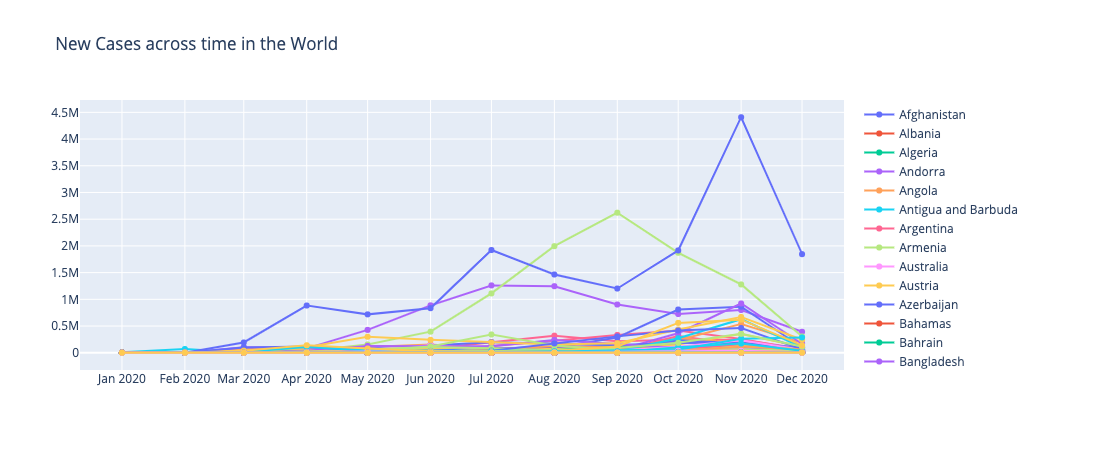

In [75]:
"""
Use the controls on the top right of the chars to zoom in and out, 
or to select a specific part of the graph
"""

fig = go.Figure()

for idx in cases_countries:
    country_data = cases_plotting_df.loc[idx]
    fig.add_trace(go.Scatter(x=country_data.index, y=country_data.new_cases,
                             mode='lines+markers', name=idx))

fig.update_layout(title="New Cases across time in the World", 
                  xaxis_nticks=16,
                  yaxis_nticks=20)
fig.show()

### New Cases - Scatter

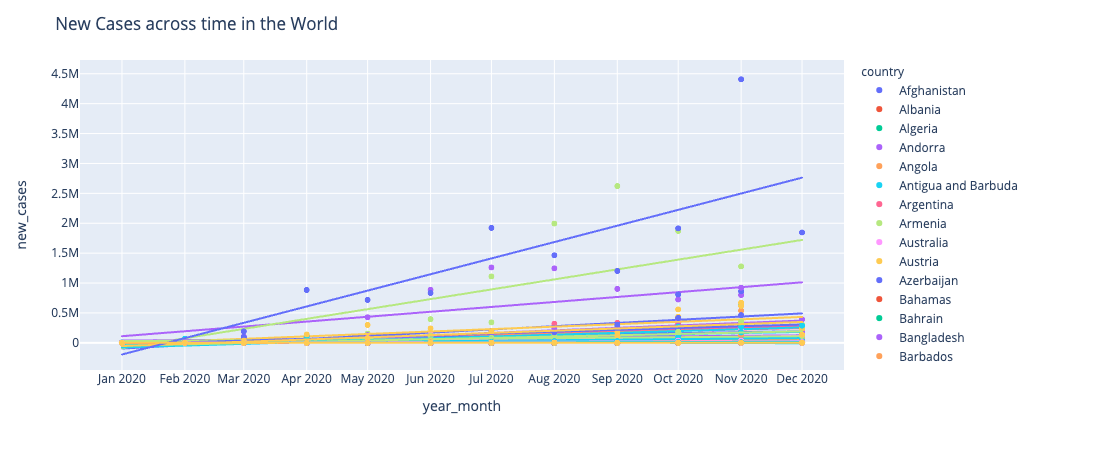

In [76]:
scatter_plot_cases_df = cases_plotting_df.reset_index()

fig = px.scatter(scatter_plot_cases_df, 
                 x=scatter_plot_cases_df.year_month, 
                 y=scatter_plot_cases_df.new_cases, 
                 color=scatter_plot_cases_df.country, 
                 trendline='ols')

fig.update_layout(title="New Cases across time in the World",
                  xaxis_nticks=16,
                  yaxis_nticks=20)

fig.show()

### New Cases - Histogram (Barmode='Group')

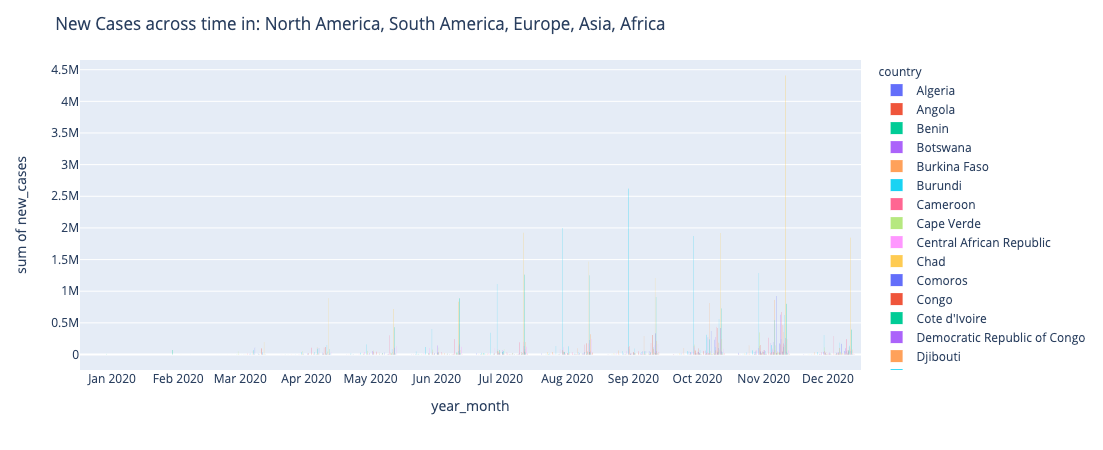

In [77]:
"""
Make sure to use the controls on the top right of the chars to ZOOM IN and OUT
or to select a specific part of the graph

You can also add/remove the continent names from the `continents` variable
to make the visualizations easier
"""

hist_plot_cases_df = cases_df.reset_index()
continents = ['North America', 'South America', 'Europe', 'Asia', 'Africa']

hist_plot_cases_df = hist_plot_cases_df[hist_plot_cases_df['continent'].isin(continents)]

fig = px.histogram(hist_plot_cases_df, 
                   x=hist_plot_cases_df.year_month, 
                   y=hist_plot_cases_df.new_cases, 
                   color=hist_plot_cases_df.country)

fig.update_layout(title=f"New Cases across time in: {', '.join(continents)} ",
                  xaxis_nticks=16,
                  yaxis_nticks=20,
                  barmode='group')

fig.show()

### New Cases - Heatmap

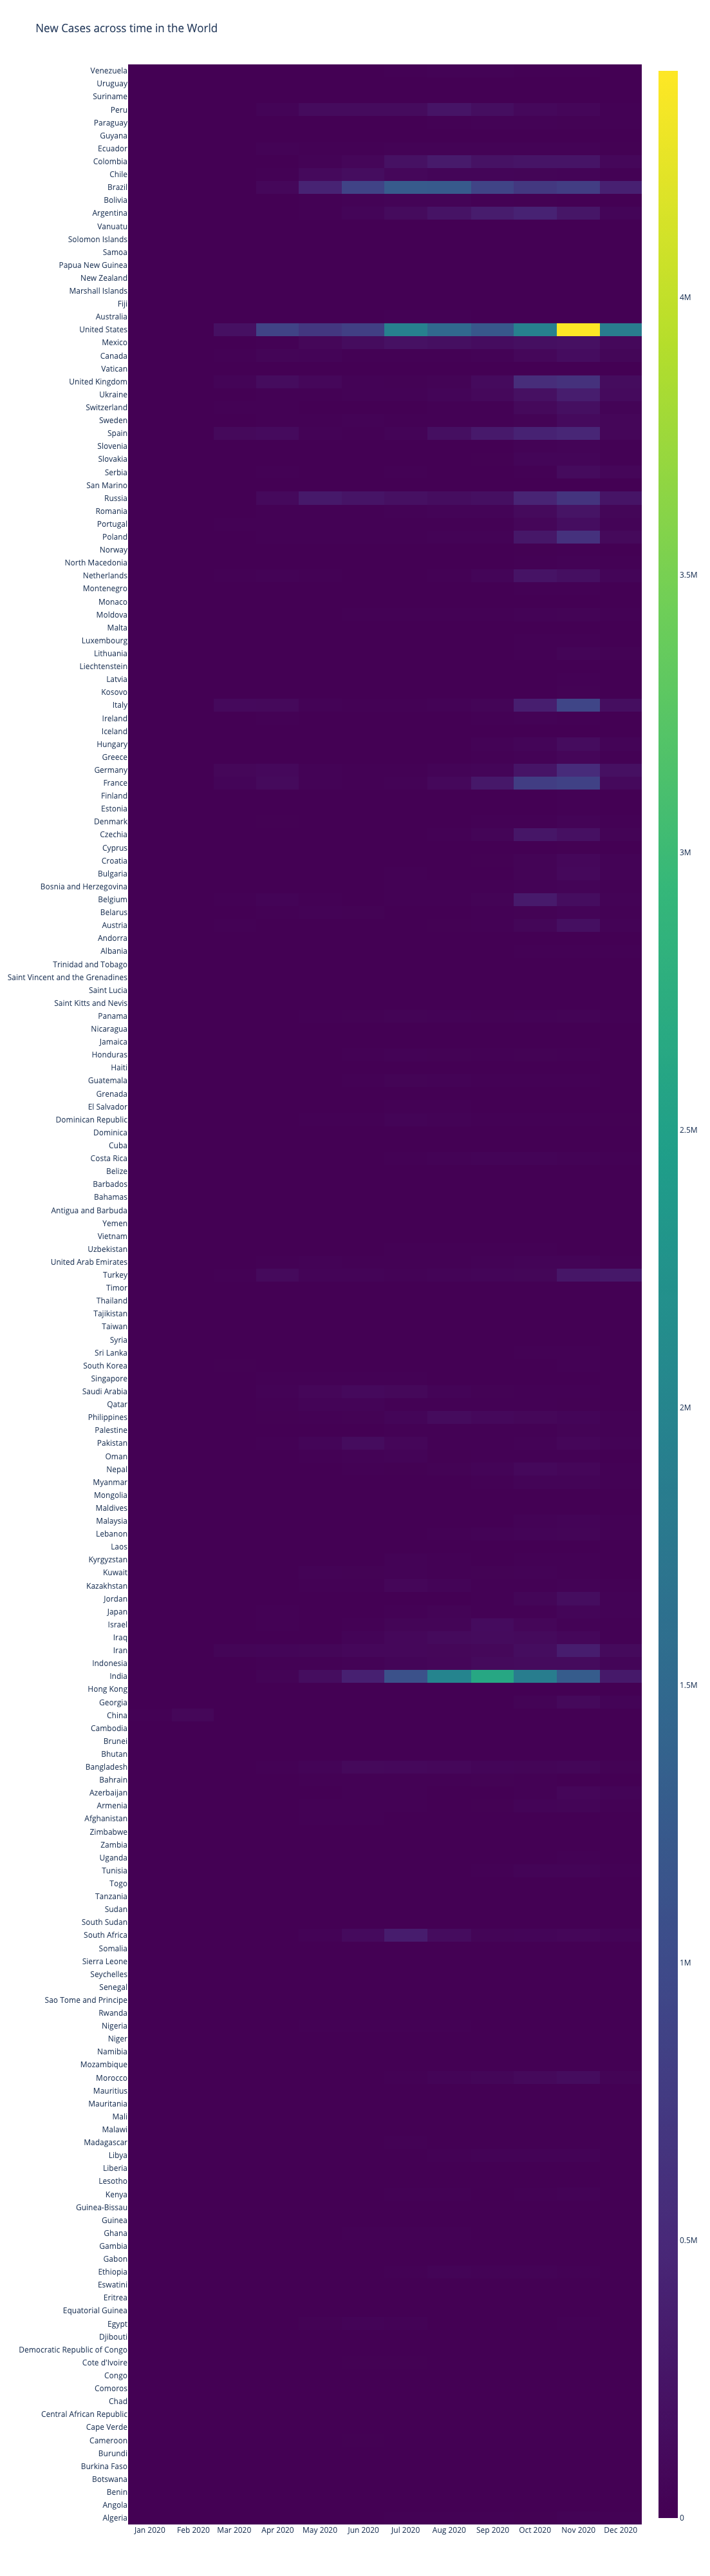

In [78]:
heatmap_plot_cases_df = cases_df.reset_index()

fig = go.Figure(data=go.Heatmap(
    x = heatmap_plot_cases_df.year_month,
    y = heatmap_plot_cases_df.country,
    z = heatmap_plot_cases_df.new_cases,
    colorscale = 'Viridis'))

fig.update_layout(
    title='New Cases across time in the World',
    xaxis_nticks=16,
    yaxis_nticks=190,
    height=4000)

fig.show()

### New Victims - Lines

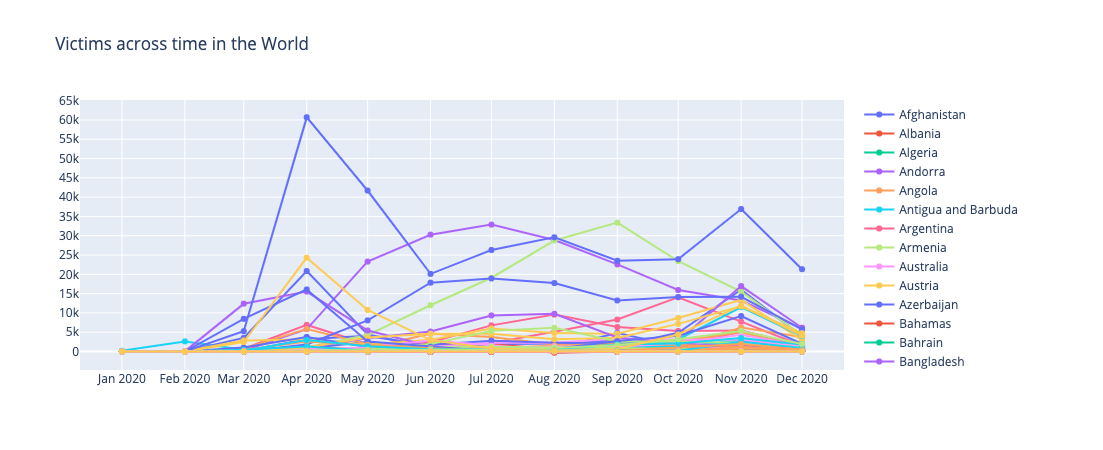

In [79]:
"""
Use the controls on the top right of the chars to zoom in and out, 
or to select a specific part of the graph
"""

fig = go.Figure()

for idx in victims_countries:
    country_data = victims_plotting_df.loc[idx]
    fig.add_trace(go.Scatter(x=country_data.index, y=country_data.new_victims,
                             mode='lines+markers', name=idx))

fig.update_layout(title="Victims across time in the World",
                  xaxis_nticks=16,
                  yaxis_nticks=20)

fig.show()

### New Victims - Scatter

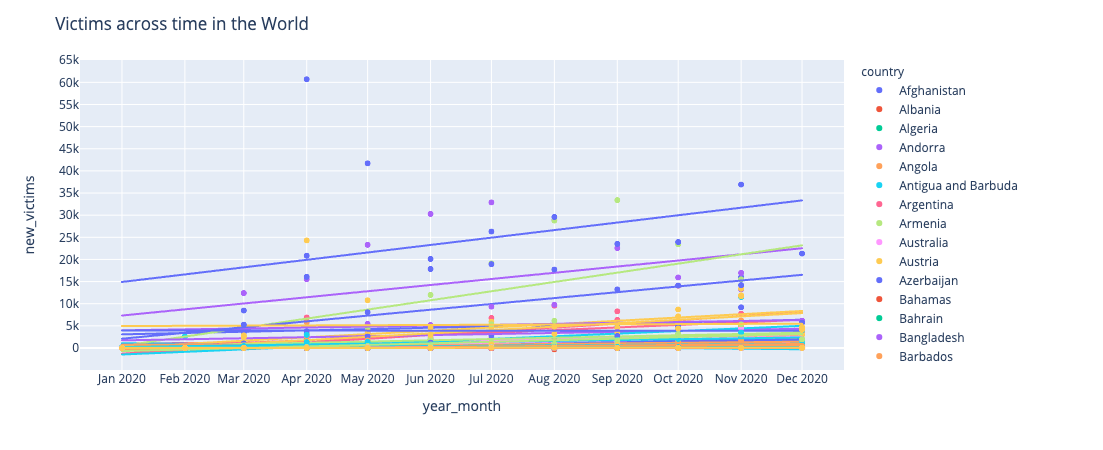

In [80]:
scatter_plot_victims_df = victims_plotting_df.reset_index()

fig = px.scatter(scatter_plot_victims_df, 
                 x=scatter_plot_victims_df.year_month, 
                 y=scatter_plot_victims_df.new_victims, 
                 color=scatter_plot_victims_df.country, 
                 trendline='ols')

fig.update_layout(title="Victims across time in the World",
                  xaxis_nticks=16,
                  yaxis_nticks=20)

fig.show()

### New Victims - Histogram (Barmode='Group')

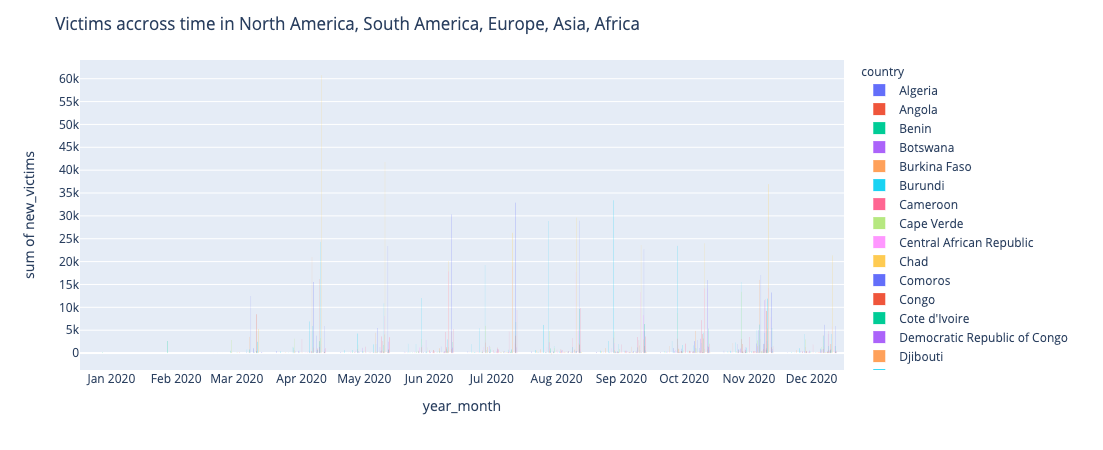

In [81]:
"""
Make sure to use the controls on the top right of the chars to ZOOM IN and OUT
or to select a specific part of the graph

You can also add/remove the continent names from the `continents` variable
to make the visualizations easier
"""

hist_plot_victims_df = victims_df.reset_index()
continents = ['North America', 'South America', 'Europe', 'Asia', 'Africa']

hist_victim_data = hist_plot_victims_df[hist_plot_victims_df['continent'].isin(continents)]

fig = px.histogram(hist_plot_victims_df, 
                   x=hist_plot_victims_df.year_month, 
                   y=hist_plot_victims_df.new_victims, 
                   color=hist_plot_victims_df.country)

fig.update_layout(title=f"Victims accross time in {', '.join(continents)} ",
                  xaxis_nticks=16,
                  yaxis_nticks=20,
                  barmode='group')

fig.show()

### New Victims - Heatmap

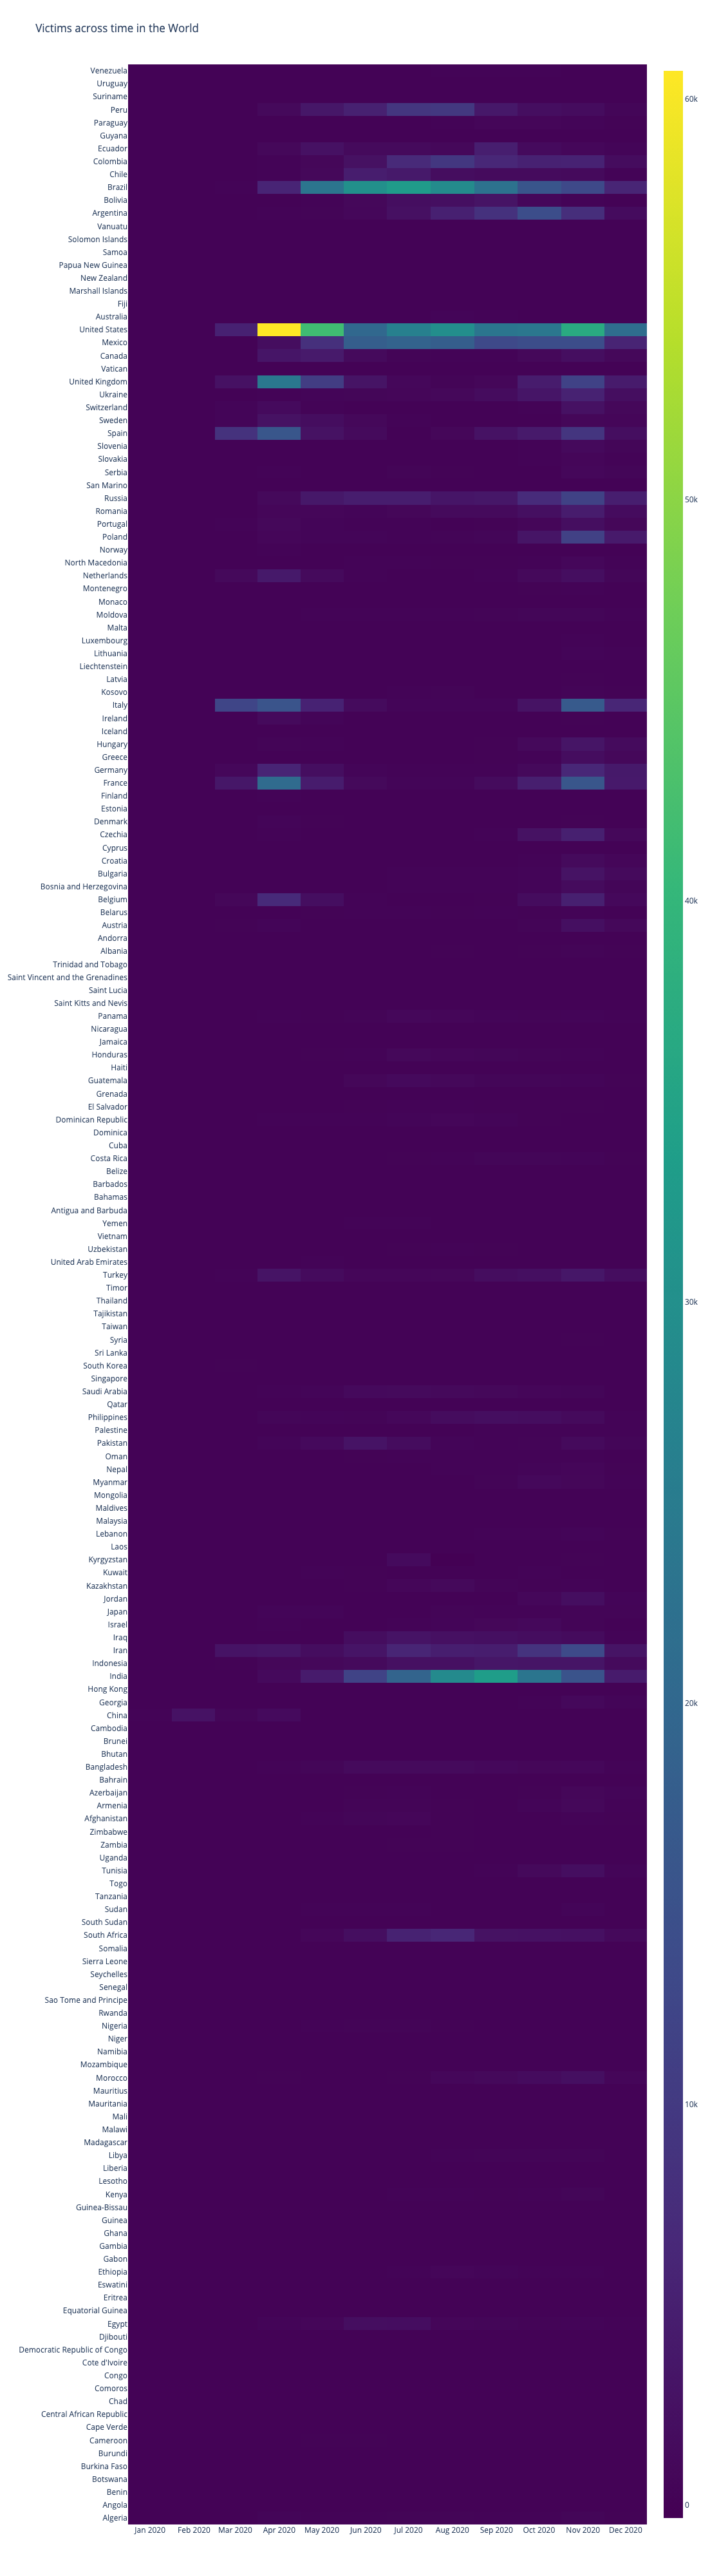

In [82]:
heatmap_plot_victims_df = victims_df.reset_index()

fig = go.Figure(data=go.Heatmap(
    x = heatmap_plot_victims_df.year_month,
    y = heatmap_plot_victims_df.country,
    z = heatmap_plot_victims_df.new_victims,
    colorscale = 'Viridis'    
))

fig.update_layout(
    title='Victims across time in the World',
    xaxis_nticks=16,
    yaxis_nticks=190,
    height=4000
  )

fig.show()